### Overview

In financial risk management, Value-at-Risk (VaR) is a commonly used risk measure, which tries to answer the following question: What loss is such that it will only be exceeded 100p% of the time in the next K trading days? Many techniques have been developed to estimate VaR. This notebook will demostrate several techniques to calculate VaR of the portfolio consisting of just one security -- Hang Seng Index fund.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime
from scipy.stats import norm

### Data

The HSI data from year 2010 to 2021 is used in this notebook. It is assumed that the return of the portfolio is the same as that of HSI. The data is obtained from Yahoo Finance

In [2]:
df_hsi = pd.read_csv('HSI_2010_2021.csv')
df_hsi['Date'] = pd.to_datetime(df_hsi['Date'], format='%Y-%m-%d')
df_hsi.dropna(inplace=True)
df_hsi

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,21860.039063,22024.830078,21689.220703,21823.279297,21823.279297,1.006200e+09
1,2010-01-05,22092.150391,22297.039063,21987.269531,22279.580078,22279.580078,1.965585e+09
2,2010-01-06,22357.460938,22514.789063,22277.130859,22416.669922,22416.669922,2.100234e+09
3,2010-01-07,22548.029297,22548.029297,22169.609375,22269.449219,22269.449219,1.495365e+09
4,2010-01-08,22282.750000,22443.220703,22206.160156,22296.750000,22296.750000,1.626023e+09
...,...,...,...,...,...,...,...
2957,2021-12-23,23141.789063,23264.750000,23027.150391,23193.640625,23193.640625,1.387904e+09
2958,2021-12-24,23375.990234,23383.189453,23186.570313,23223.759766,23223.759766,6.228797e+08
2959,2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,1.433027e+09
2960,2021-12-29,23253.980469,23253.980469,23008.279297,23086.539063,23086.539063,8.284144e+08


### Historical Simulation

Historical simulation is a non-parametric method which assumes that the distribution of tomorrow's portfolio returns is approximated by the empirical distribution of the past N observations.

For example, suppose N = 250. In order to calculate the 1% VaR of return on day 251, we need to find the 1st percentile of return between day 1 and day 250.

##### Note: VaR is treated as negative value in this notebook (although it is defined as positive number by convention)

In [3]:
def historical_simulation(df, N = 250, p=0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    N: int
        Calculate VaR by using past N daily returns
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_hs' specifying VaR of return 
    '''
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace = True)
    df['tmr_VaR_hs'] = df['Return'].rolling(window=N).apply(lambda x: np.quantile(x, p)) #calculate tomorrow's VaR
    df['VaR_hs'] = df['tmr_VaR_hs'].shift(1)
    return df

N = 250, p = 0.01. Percentage of day with return smaller than VaR = 0.018484288354898338
N = 500, p = 0.01. Percentage of day with return smaller than VaR = 0.013441955193482688
N = 750, p = 0.01. Percentage of day with return smaller than VaR = 0.013605442176870748
N = 1000, p = 0.01. Percentage of day with return smaller than VaR = 0.011253196930946292


Text(0.5, 1.0, '1-day VaR')

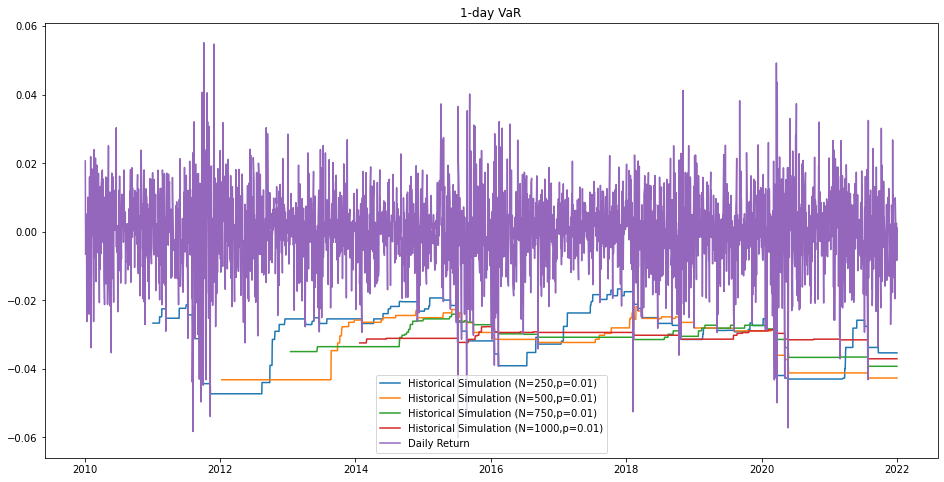

In [4]:
# Visualize the result by using different number of past observations (i.e. N) to calculate VaR

fig, ax = plt.subplots(figsize=(16,8))
for N, p in [(250,0.01),(500,0.01),(750,0.01), (1000,0.01)]:
    df_tmp = df_hsi.copy(deep=True)
    df_tmp = historical_simulation(df_tmp, N, p)
    num_below = len(np.where(df_tmp['Return']<df_tmp['VaR_hs'])[0])
    num_above = len(np.where(df_tmp['Return']>=df_tmp['VaR_hs'])[0])
    print('N = {}, p = {}. Percentage of day with return smaller than VaR = {}'.format(N,p,num_below/(num_below+num_above)))
    ax.plot(df_tmp['Date'], df_tmp['VaR_hs'], label='Historical Simulation (N={},p={})'.format(N,p))
ax.plot(df_tmp['Date'],df_tmp['Return'], label='Daily Return')
plt.legend()
plt.title('1-day VaR')

Notice that the smaller value of N, the more dynamic patterns of VaR (i.e. more responsive to the most recent return). Also, although 1% VaR is calculated, the percentage of day with return smaller than VaR is higher than 1%. This shows that historical simulation VaR tends to overestimate risk when the market volatility is low, and underestimate risk when the market volatility is high.

### Age-Weighted Historical Simulation

Age-Weighted Historical Simulation is also a non-parametric method which is similar to Historical Simulation. The difference is that more weight is assigned to the most recent observations and relatively less weight to the returns further in the past. For example, suppose we look back N=250 days to estimate the VaR on day 251. The weight of return on day (251-i) is (W^(i-1))*(1-W)/(1-W^250) for i = 1,2,...,250, where W is a depreciating factor and 0<W<1 . Then the observations along with their assigned weights are sorted in ascending order. Finally, the 100p% VaR is calculated by accumulating the weights of the ascending returns until 100p% is reached. 


In [5]:
def weighted_historical_simulation(df, N = 250, W = 0.99, p = 0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    N: int
        Calculate VaR by using past N daily returns
    W: float
        Depreciating factor for calculating the weight
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_whs' specifying VaR of return
    '''
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace = True)
    def helper(x):
        '''
        Parameters
        -----------
        x: array
            array of column 'Return' from df

        Returns
        ----------
        float
            VaR of return
        '''
        weights = W ** (np.arange(N,0,-1) - 1)*(1 - W)/(1 - W** N) 
        sorted_return = np.sort(x)
        sorted_weights = weights[np.argsort(x)]  # sort the weight by ascending order of return
        idx = np.where(sorted_weights.cumsum()<=p)[0] # find the index of sorted_return such that cummulated sum of their weights is smaller than p
        if len(idx) == 0: 
            return sorted_return[0]
        else:
            return sorted_return[np.max(idx)]
    df['tmr_VaR_whs'] = df['Return'].rolling(window = N).apply(helper)
    df['VaR_whs'] = df['tmr_VaR_whs'].shift(1)
    return df
    
    
    

N = 250, W = 0.99. Percentage of day with return smaller than VaR = 0.009611829944547136
N = 250, W = 0.95. Percentage of day with return smaller than VaR = 0.02144177449168207
N = 500, W = 0.99. Percentage of day with return smaller than VaR = 0.009775967413441956
N = 500, W = 0.95. Percentage of day with return smaller than VaR = 0.021588594704684317


Text(0.5, 1.0, '1-day 1% VaR')

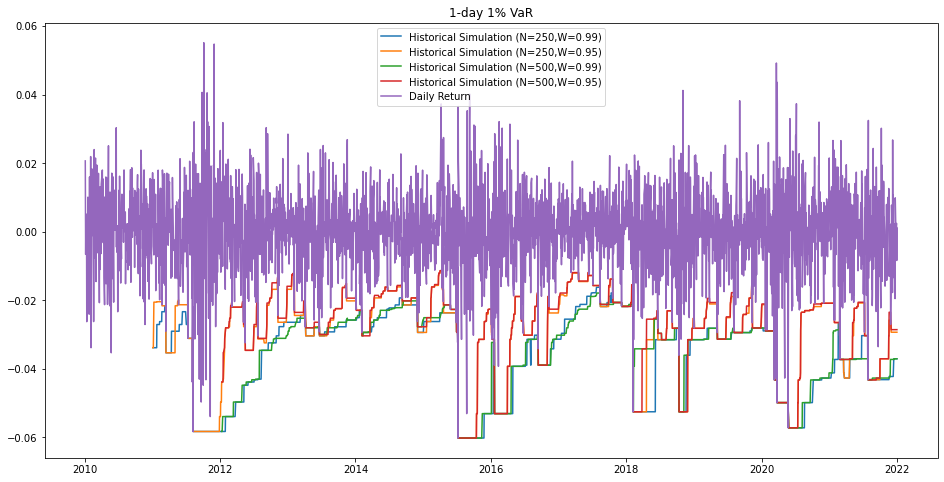

In [6]:
# Visualize the result by using different number of past observations (N) and depreciating factor (W) to calculate VaR

fig, ax = plt.subplots(figsize=(16,8))
for N, W in [(250,0.99),(250,0.95),(500,0.99), (500, 0.95)]:
    df_tmp = df_hsi.copy(deep=True)
    df_tmp = weighted_historical_simulation(df_tmp, N, W)
    num_below = len(np.where(df_tmp['Return']<df_tmp['VaR_whs'])[0])
    num_above = len(np.where(df_tmp['Return']>=df_tmp['VaR_whs'])[0])
    print('N = {}, W = {}. Percentage of day with return smaller than VaR = {}'.format(N,W,num_below/(num_below+num_above)))
    ax.plot(df_tmp['Date'], df_tmp['VaR_whs'], label='Historical Simulation (N={},W={})'.format(N,W))
ax.plot(df_tmp['Date'],df_tmp['Return'], label='Daily Return')
plt.legend()
plt.title('1-day 1% VaR')

Note that smaller W (depreciating factor) tends to produce more dynamic pattern of VaR as the depreciating rate increases when W decreases. Therefore, more weight is assigned to more current return and VaR is more responsive to the most recent return. However, the change in N (number of past observations used to calculate VaR) has less effect on VaR when compared with W. 

### VaR Forecasting by GARCH Model

Although non-parametric methods like Historical Simulation is easy to compute, it has several disavantages. For example, the VaR you get from Historical Simulation can never be greater than maximum loss in the historical data, which is not the case in reality. Therefore, it is also common to use parametric methods to estimate the VaR. A common method is to assume that the daily return is normally distributed. Then we can estimate the VaR by {mean_return + z * standard_deviation_of_return}, where z is the 100p-percentile of normal distribution. The mean_return and standard_deviation can vary time to time but historical data tell us that daily mean_return tends to be a constant close to zero . Therefore, it is more important to model the change of volatility so as to better estimate the VaR of return. 

GARCH(1,1) model is a classic model for modelling the variance dynamics. It assumes that next day's variance is linear combination of square of today's return and today's variance (i.e. Variance{t+1} = omega + alpha * Return{t}^2 + Beta * Variance{t}, where omega, alpha and beta are parameters that can be optimized through Maximum Likelihood Estimation). By using the estimation of next day's variance, we can forecast the VaR of return next day given that the daily return is assumed to be normally distributed. 

The following code will first train a GARCH model by using data before a specified date. Then VaR is estimated for the date after the specified date.

In [7]:
def GARCH_VaR(df, split_date, p = 0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    split_date: str or datetime obj
        The data before split_date is used to estimate parameters in GARCH model.
        Then the forecasts will be produced for the date after the split_date.
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_GARCH' specifying VaR of return
    '''
    z = norm.ppf(p) # calculate 100p-percentile of Normal distribution
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace=True)
    ret = df.set_index('Date')['Return'] 
    model = arch.arch_model(ret, rescale=False) # create GARCH(1,1) model
    res = model.fit(last_obs=split_date) # train a GARCH model by using data before a specified date
    forecasts = res.forecast(horizon=5, start=split_date, reindex=False) # estimate the variance based on trained model
#     tmr_mean = forecasts.mean['h.1'].reset_index() # choose one_day_ahead prediction for mean
#     tmr_mean.rename(columns={'h.1':'tmr_mean'}, inplace=True)
#     df = pd.merge(df, tmr_mean, on='Date')
    tmr_variance = forecasts.variance['h.1'].reset_index() # choose one_day_ahead prediction for Varicance
    tmr_variance.rename(columns={'h.1':'tmr_variance'}, inplace=True)
    df = pd.merge(df, tmr_variance, on='Date')
    df['tmr_VaR_GARCH'] = z * np.sqrt(df['tmr_variance'])
    df['VaR_GARCH'] = df['tmr_VaR_GARCH'].shift(1)
    return df

In [8]:
df_tmp = df_hsi.copy(deep=True)
split_date = datetime.datetime(2015,12,31) # use half of data for training the model
df_tmp = GARCH_VaR(df_tmp, split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3765071663.970616
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2.0465911513153806e+19
Iteration:      3,   Func. Count:     30,   Neg. LLF: 78837012.62516682
Iteration:      4,   Func. Count:     42,   Neg. LLF: 8108492.172501539
Iteration:      5,   Func. Count:     53,   Neg. LLF: -4544.585009513071
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4544.5850145862605
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 5


0.02234258632362898


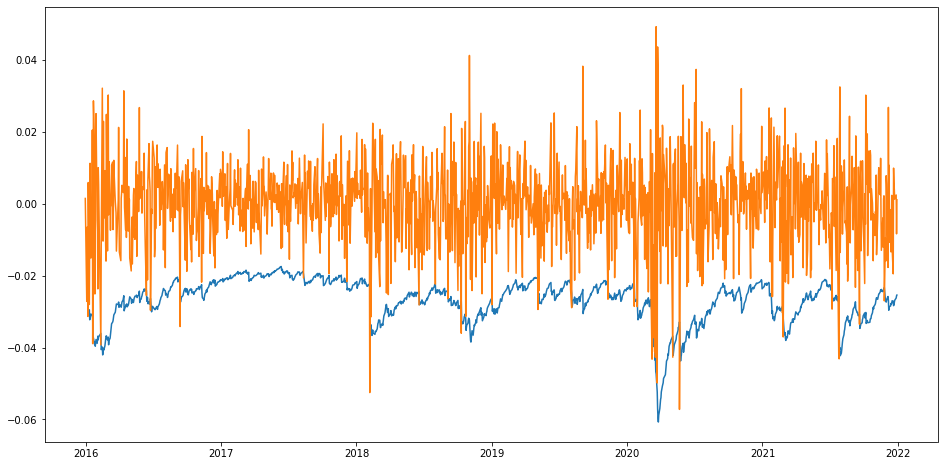

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_tmp['Date'], df_tmp['VaR_GARCH'])
ax.plot(df_tmp['Date'], df_tmp['Return'])
num_below = len(np.where(df_tmp['Return']<df_tmp['VaR_GARCH'])[0])
num_above = len(np.where(df_tmp['Return']>=df_tmp['VaR_GARCH'])[0])
print(num_below/(num_below+num_above))

From the figure above, we can see that GARCH VaR response quickly to the change in market volatility. The VaR of return drops significantly when the daily return greatly deviate from zero. Then the VaR also increases quickly when the daily restores to normal level. Therefore, unlike Historical Simulation method, GARCH VaR is able to capture the significant change in market volatility while avoid overestimating the loss when market volatility is small.